# Netflix Stock Prediction

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import plotly.express as px
from pmdarima import auto_arima
from scipy import stats 
from statsmodels.tsa.statespace.sarimax import SARIMAX 
from statsmodels.tsa.stattools import adfuller
from statsmodels.tsa.seasonal import seasonal_decompose
import statsmodels.graphics.tsaplots as sgt
from statsmodels.tsa.arima.model import ARIMA
from scipy.stats.distributions import chi2
import itertools

In [2]:
df_raw=pd.read_csv('NFLX.csv')
df=df_raw.copy()

In [3]:
df.head()

,Date,Open,High,Low,Close,Adj Close,Volume
0,2018-02-05,262.000000,267.899994,250.029999,254.259995,254.259995,11896100
1,2018-02-06,247.699997,266.700012,245.000000,265.720001,265.720001,12595800
2,2018-02-07,266.579987,272.450012,264.329987,264.559998,264.559998,8981500
3,2018-02-08,267.079987,267.619995,250.000000,250.100006,250.100006,9306700
4,2018-02-09,253.850006,255.800003,236.110001,249.470001,249.470001,16906900


In [4]:
df.describe().apply(lambda s: s.apply('{0:.5f}'.format)) .T

,count,mean,std,min,25%,50%,75%,max
Open,1009.00000,419.05967,108.53753,233.92000,331.48999,377.76999,509.13000,692.34998
High,1009.00000,425.32070,109.26296,250.64999,336.29999,383.01001,515.63000,700.98999
Low,1009.00000,412.37404,107.55587,231.23000,326.00000,370.88000,502.53000,686.09003
Close,1009.00000,419.00073,108.29000,233.88001,331.62000,378.67001,509.07999,691.69000
Adj Close,1009.00000,419.00073,108.29000,233.88001,331.62000,378.67001,509.07999,691.69000
Volume,1009.00000,7570685.03469,5465535.22569,1144000.00000,4091900.00000,5934500.00000,9322400.00000,58904300.00000


### Close & Adj Close are identical

In [5]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1009 entries, 0 to 1008
Data columns (total 7 columns):
 #   Column     Non-Null Count  Dtype  
---  ------     --------------  -----  
 0   Date       1009 non-null   object 
 1   Open       1009 non-null   float64
 2   High       1009 non-null   float64
 3   Low        1009 non-null   float64
 4   Close      1009 non-null   float64
 5   Adj Close  1009 non-null   float64
 6   Volume     1009 non-null   int64  
dtypes: float64(5), int64(1), object(1)
memory usage: 55.3+ KB


In [6]:
df.Date=pd.to_datetime(df.Date,dayfirst=True)

In [7]:
df.Date.describe()

C:\Users\karee\AppData\Local\Temp\ipykernel_22148\3950465283.py:1: FutureWarning: Treating datetime data as categorical rather than numeric in `.describe` is deprecated and will be removed in a future version of pandas. Specify `datetime_is_numeric=True` to silence this warning and adopt the future behavior now.
  df.Date.describe()


count                    1009
unique                   1009
top       2018-02-05 00:00:00
freq                        1
first     2018-02-05 00:00:00
last      2022-02-04 00:00:00
Name: Date, dtype: object

In [8]:
df.set_index('Date',inplace=True)
df.head()

,Open,High,Low,Close,Adj Close,Volume
Date,,,,,,
2018-02-05,262.000000,267.899994,250.029999,254.259995,254.259995,11896100
2018-02-06,247.699997,266.700012,245.000000,265.720001,265.720001,12595800
2018-02-07,266.579987,272.450012,264.329987,264.559998,264.559998,8981500
2018-02-08,267.079987,267.619995,250.000000,250.100006,250.100006,9306700
2018-02-09,253.850006,255.800003,236.110001,249.470001,249.470001,16906900


In [9]:
df=df.asfreq('b')   
df.head(10)

,Open,High,Low,Close,Adj Close,Volume
Date,,,,,,
2018-02-05,262.000000,267.899994,250.029999,254.259995,254.259995,11896100.0
2018-02-06,247.699997,266.700012,245.000000,265.720001,265.720001,12595800.0
2018-02-07,266.579987,272.450012,264.329987,264.559998,264.559998,8981500.0
2018-02-08,267.079987,267.619995,250.000000,250.100006,250.100006,9306700.0
2018-02-09,253.850006,255.800003,236.110001,249.470001,249.470001,16906900.0
2018-02-12,252.139999,259.149994,249.000000,257.950012,257.950012,8534900.0
2018-02-13,257.290009,261.410004,254.699997,258.269989,258.269989,6855200.0
2018-02-14,260.470001,269.880005,260.329987,266.000000,266.000000,10972000.0
2018-02-15,270.029999,280.500000,267.630005,280.269989,280.269989,10759700.0


In [10]:
df.isnull().sum()

Open         36
High         36
Low          36
Close        36
Adj Close    36
Volume       36
dtype: int64

In [11]:
df.fillna(method='bfill',inplace=True)
df.isna().sum()

Open         0
High         0
Low          0
Close        0
Adj Close    0
Volume       0
dtype: int64

In [12]:
px.line(df,df.index,['Adj Close','Close'],title='<b>Stock Prices of Netflix', template="plotly_dark")

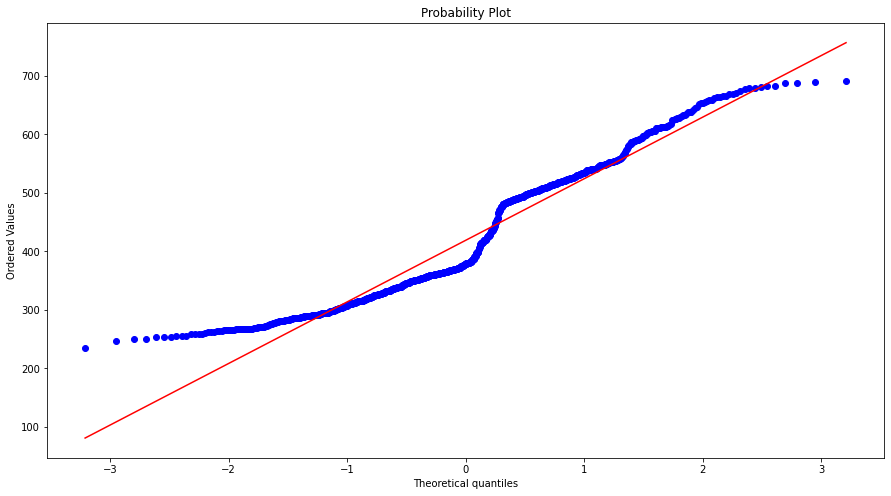

In [13]:
fig = plt.figure(figsize=(15,8))
res = stats.probplot(df['Adj Close'], plot=plt)

### It does not fit the normal distribution perfectly

In [14]:
adfuller(df.Close)

(-1.7816206078015773,
 0.38962396994855164,
 14,
 1030,
 {'1%': -3.436714730058834,
  '5%': -2.8643501440982058,
  '10%': -2.5682662399849185},
 7779.600969835532)

#### The data is not stationary as p value is greater than 0.05

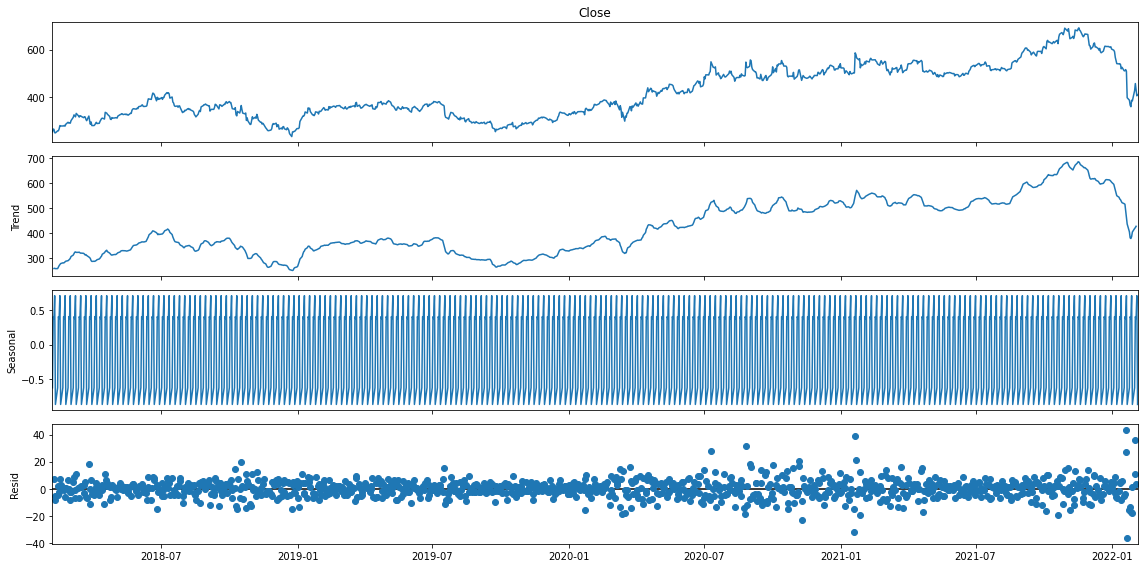

In [15]:
plt.rc("figure", figsize=(16,8))
additive=seasonal_decompose(df.Close,model='additive')
additive.plot();

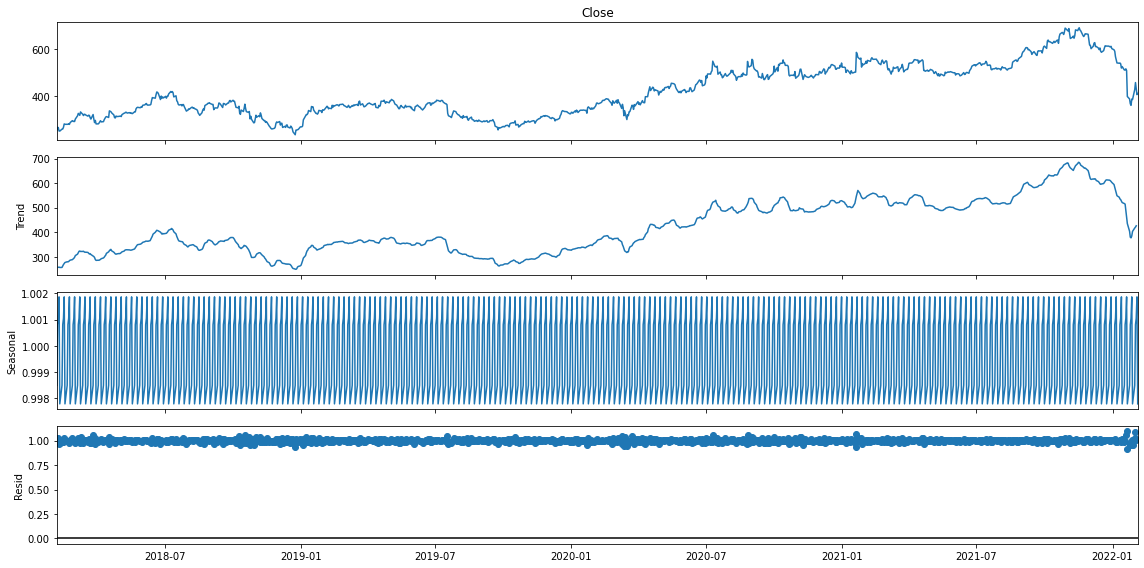

In [16]:
multiplicative=seasonal_decompose(df.Close,model='multiplicative')
multiplicative.plot();

### There is no seasonality and what affects the closing price are the previous days

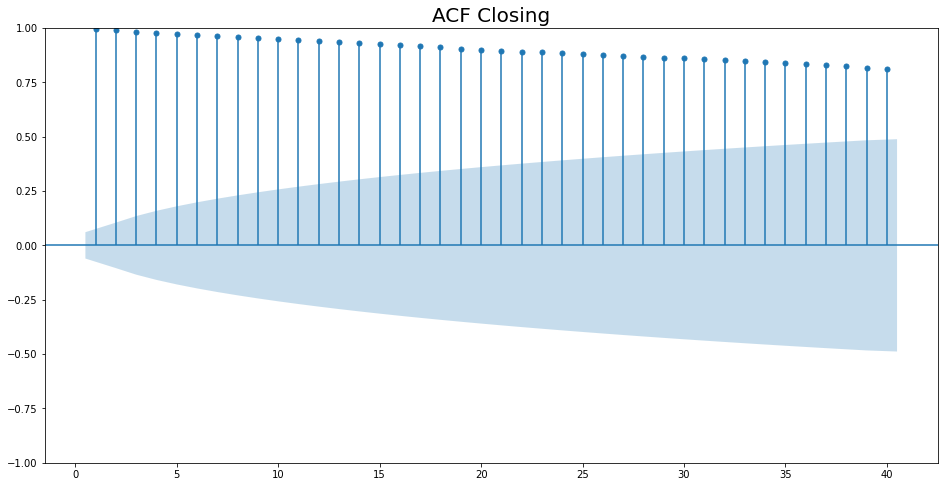

In [17]:
sgt.plot_acf(df.Close,lags=40,zero=False)
plt.title("ACF Closing",fontdict={'fontsize':20})
plt.show()

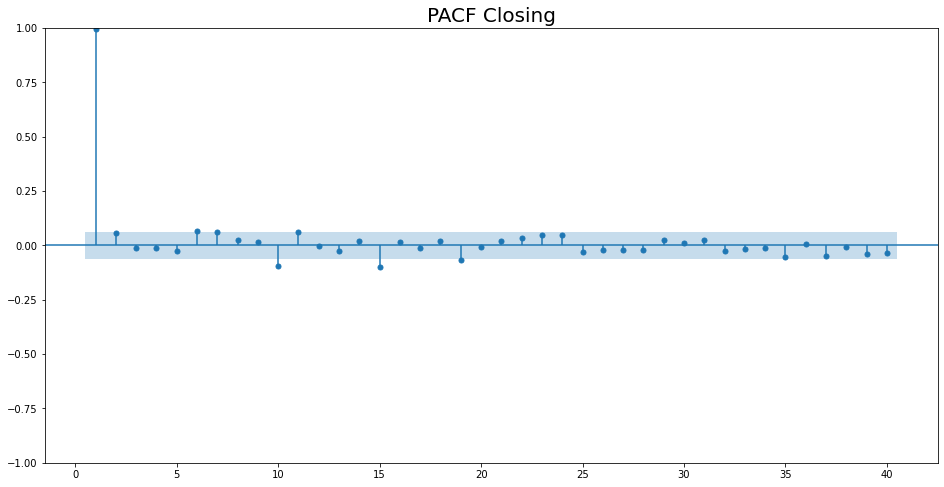

In [18]:
sgt.plot_pacf(df.Close,lags=40,zero=False,method='ols')
plt.title("PACF Closing",fontdict={'fontsize':20})
plt.show()

In [19]:
def LLR_test(mod_1,mod_2,DF=1):
    L1=mod_1.fit().llf
    L2=mod_2.fit().llf
    LR=2*(L2-L1)
    p=chi2.sf(LR,DF).round(3)
    return p


### Creating returns column

In [20]:
df['Returns']=df.Close.pct_change(1).mul(100)
df.Returns.describe().T

count    1044.000000
mean        0.080215
std         2.614056
min       -21.790457
25%        -1.147976
50%         0.000000
75%         1.387735
max        16.854344
Name: Returns, dtype: float64

In [21]:
adfuller(df.Returns.iloc[1:])

(-8.216231683062334,
 6.612803369986294e-13,
 13,
 1030,
 {'1%': -3.436714730058834,
  '5%': -2.8643501440982058,
  '10%': -2.5682662399849185},
 4847.2580334341765)

### Returns are obviously stationary

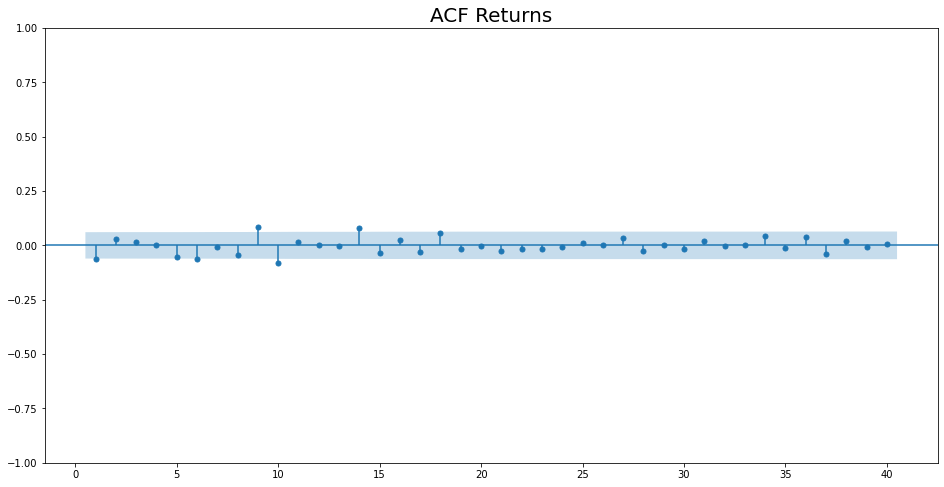

In [22]:
sgt.plot_acf(df.Returns.iloc[1:],lags=40,zero=False)
plt.title("ACF Returns",fontdict={'fontsize':20})
plt.show()

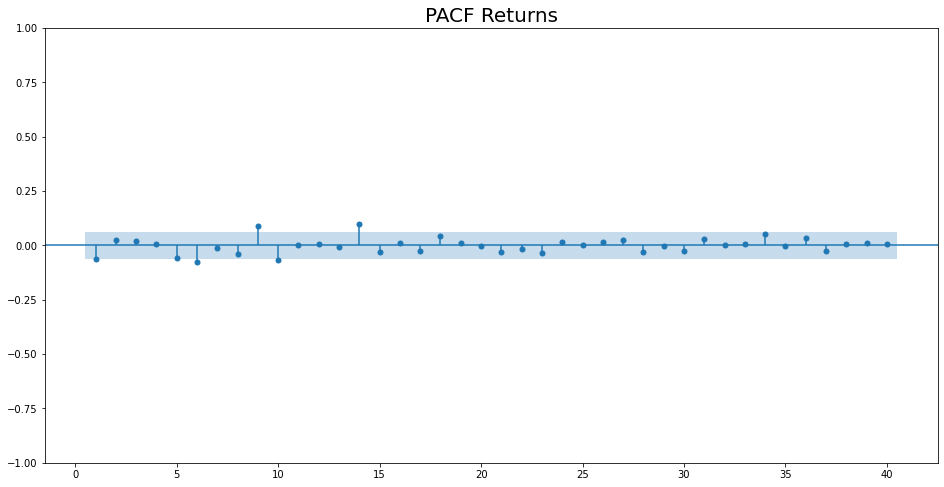

In [23]:
sgt.plot_pacf(df.Returns.iloc[1:],lags=40,zero=False,method='ols')
plt.title("PACF Returns",fontdict={'fontsize':20})
plt.show()

## Transform Prices to make it stationary

In [24]:
df["Close_shift"]=df.Close-df.Close.shift(1)
adfuller(df.Close_shift.iloc[1:])

(-7.941004410502594,
 3.3141082417312317e-12,
 13,
 1030,
 {'1%': -3.436714730058834,
  '5%': -2.8643501440982058,
  '10%': -2.5682662399849185},
 7773.464602230366)

In [25]:
px.line(df,df.index,['Close_shift'],title='<b>Closing prices shifted by 1', template="plotly_dark")


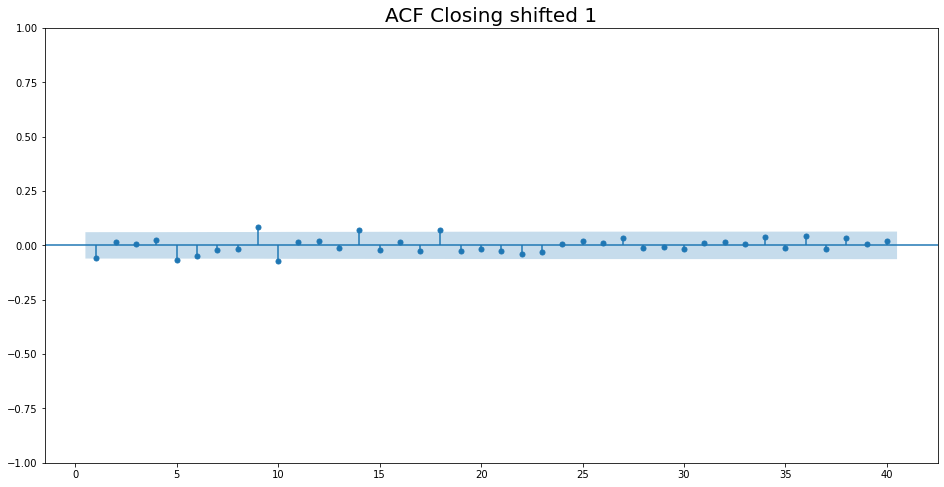

In [26]:
sgt.plot_acf(df.Close_shift.iloc[1:],lags=40,zero=False)
plt.title("ACF Closing shifted 1",fontdict={'fontsize':20})
plt.show()

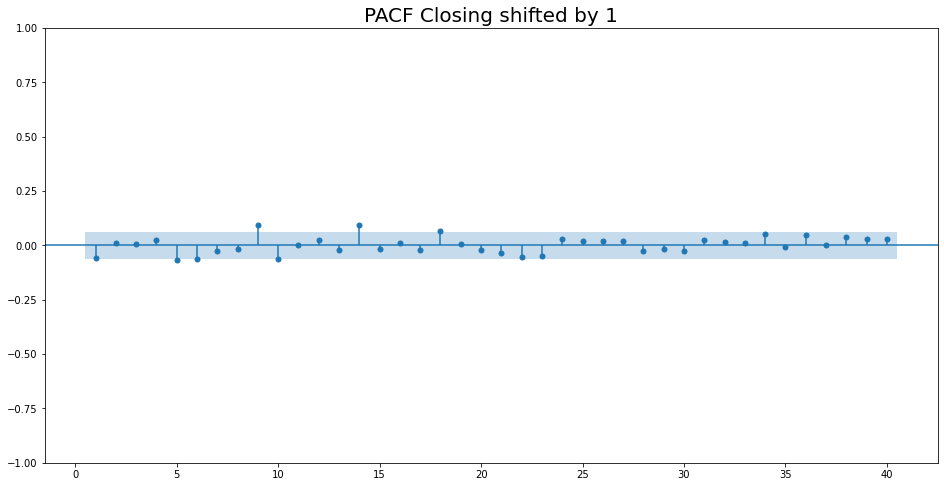

In [27]:
sgt.plot_pacf(df.Close_shift.iloc[1:],lags=40,zero=False,method='ols')
plt.title("PACF Closing shifted by 1",fontdict={'fontsize':20})
plt.show()

### From 1 transformation, the series became stationary, that means d=1 in ARIMA

## Splitting Data

In [28]:
# size=len(df)
# df_test=df.iloc[int(size*0.9):]
# df=df.iloc[:int(size*0.9)]
# df.shape,df_test.shape

#### ARIMA(1,1,1)

In [29]:
arima_111=ARIMA(df.Close,order=(1,1,1))
result_arima_111=arima_111.fit()
result_arima_111.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                               SARIMAX Results                                
==============================================================================
Dep. Variable:                  Close   No. Observations:                 1045
Model:                 ARIMA(1, 1, 1)   Log Likelihood               -3969.369
Date:                Sun, 10 Sep 2023   AIC                           7944.737
Time:                        18:34:04   BIC                           7959.590
Sample:                    02-05-2018   HQIC                          7950.370
                         - 02-04-2022                                         
Covariance Type:                  opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1         -0.2548      0.429     -0.594      0.552      -1.095       0.585
ma.L1          0.1982      0.436      0.455      0.649      -0.656       1.053
sigma2       117.4645      1.762     66.657      0.000     114.011     120.918
===================================================================================
Ljung-Box (L1) (Q):                   0.00   Jarque-Bera (JB):             10579.95
Prob(Q):                              1.00   Prob(JB):                         0.00
Heteroskedasticity (H):               2.28   Skew:                            -0.66
Prob(H) (two-sided):                  0.00   Kurtosis:                        18.54
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

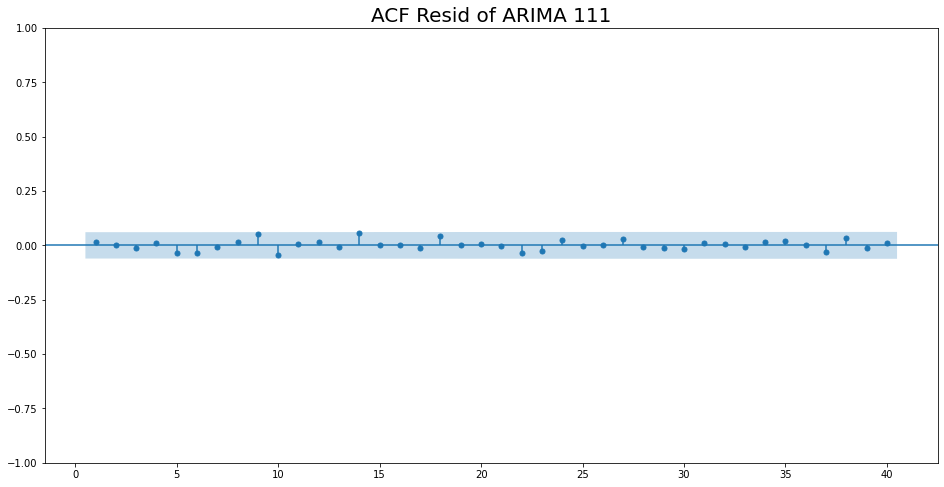

In [30]:
sgt.plot_acf(result_arima_111.resid,lags=40,zero=False)
plt.title("ACF Resid of ARIMA 111",fontdict={'fontsize':20})
plt.show()

In [31]:
def find_significant_arima_models(max_value,dict):
    arima_params = itertools.product(range(0, max_value + 1), repeat=2)

    for params in arima_params:
        p, q = params
        model = ARIMA(df.Close, order=(p, 1, q))
        result = model.fit()

        pvalues = result.pvalues
        if all(pvalue < 0.05 for pvalue in pvalues):
            print(f"ARIMA({p}, 1, {q}) - LL: {result.llf} -  AIC: {result.aic}")
            dict[f"ARIMA({p}, 1, {q})"]=model


In [32]:
dict={}
find_significant_arima_models(6,dict)

ARIMA(0, 1, 0) - LL: -3971.153496785045 -  AIC: 7944.30699357009
ARIMA(0, 1, 1) - LL: -3969.485260172641 -  AIC: 7942.970520345282
ARIMA(1, 1, 0) - LL: -3969.4383357307406 -  AIC: 7942.876671461481


C:\Users\karee\AppData\Roaming\Python\Python310\site-packages\statsmodels\tsa\statespace\sarimax.py:966: UserWarning:

Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.

C:\Users\karee\AppData\Roaming\Python\Python310\site-packages\statsmodels\tsa\statespace\sarimax.py:978: UserWarning:

Non-invertible starting MA parameters found. Using zeros as starting parameters.

C:\Users\karee\AppData\Roaming\Python\Python310\site-packages\statsmodels\tsa\statespace\sarimax.py:966: UserWarning:

Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.

C:\Users\karee\AppData\Roaming\Python\Python310\site-packages\statsmodels\tsa\statespace\sarimax.py:978: UserWarning:

Non-invertible starting MA parameters found. Using zeros as starting parameters.



ARIMA(2, 1, 2) - LL: -3963.8516792334995 -  AIC: 7937.703358466999


C:\Users\karee\AppData\Roaming\Python\Python310\site-packages\statsmodels\tsa\statespace\sarimax.py:966: UserWarning:

Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.

C:\Users\karee\AppData\Roaming\Python\Python310\site-packages\statsmodels\tsa\statespace\sarimax.py:978: UserWarning:

Non-invertible starting MA parameters found. Using zeros as starting parameters.

C:\Users\karee\AppData\Roaming\Python\Python310\site-packages\statsmodels\base\model.py:607: ConvergenceWarning:

Maximum Likelihood optimization failed to converge. Check mle_retvals

C:\Users\karee\AppData\Roaming\Python\Python310\site-packages\statsmodels\base\model.py:607: ConvergenceWarning:

Maximum Likelihood optimization failed to converge. Check mle_retvals

C:\Users\karee\AppData\Roaming\Python\Python310\site-packages\statsmodels\base\model.py:607: ConvergenceWarning:

Maximum Likelihood optimization failed to converge. Check mle_retvals

C:\Users\karee\AppData\Roaming\

ARIMA(4, 1, 3) - LL: -3965.2969472890145 -  AIC: 7946.593894578029


C:\Users\karee\AppData\Roaming\Python\Python310\site-packages\statsmodels\base\model.py:607: ConvergenceWarning:

Maximum Likelihood optimization failed to converge. Check mle_retvals

C:\Users\karee\AppData\Roaming\Python\Python310\site-packages\statsmodels\base\model.py:607: ConvergenceWarning:

Maximum Likelihood optimization failed to converge. Check mle_retvals

C:\Users\karee\AppData\Roaming\Python\Python310\site-packages\statsmodels\base\model.py:607: ConvergenceWarning:

Maximum Likelihood optimization failed to converge. Check mle_retvals

C:\Users\karee\AppData\Roaming\Python\Python310\site-packages\statsmodels\tsa\statespace\sarimax.py:966: UserWarning:

Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.

C:\Users\karee\AppData\Roaming\Python\Python310\site-packages\statsmodels\tsa\statespace\sarimax.py:978: UserWarning:

Non-invertible starting MA parameters found. Using zeros as starting parameters.

C:\Users\karee\AppData\Roaming\

### As ARIMA 212 is nested in ARIMA 413 we should do the LLR test

In [33]:
LLR_test(dict['ARIMA(2, 1, 2)'],dict['ARIMA(4, 1, 3)'],DF=3)

C:\Users\karee\AppData\Roaming\Python\Python310\site-packages\statsmodels\tsa\statespace\sarimax.py:966: UserWarning:

Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.

C:\Users\karee\AppData\Roaming\Python\Python310\site-packages\statsmodels\tsa\statespace\sarimax.py:978: UserWarning:

Non-invertible starting MA parameters found. Using zeros as starting parameters.

C:\Users\karee\AppData\Roaming\Python\Python310\site-packages\statsmodels\base\model.py:607: ConvergenceWarning:

Maximum Likelihood optimization failed to converge. Check mle_retvals



1.0

### As the p value is greater than 5% the higher complexity is not worth it

In [34]:
model_auto=auto_arima(df.Close,max_order=None,max_p=9,max_q=9,max_d=2,maxiter=200)

In [35]:
model_auto.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                               SARIMAX Results                                
==============================================================================
Dep. Variable:                      y   No. Observations:                 1045
Model:               SARIMAX(2, 1, 2)   Log Likelihood               -3963.852
Date:                Sun, 10 Sep 2023   AIC                           7937.703
Time:                        18:34:56   BIC                           7962.457
Sample:                    02-05-2018   HQIC                          7947.092
                         - 02-04-2022                                         
Covariance Type:                  opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.6712      0.059     11.291      0.000       0.555       0.788
ar.L2         -0.8402      0.069    -12.227      0.000      -0.975      -0.706
ma.L1         -0.7219      0.048    -14.923      0.000      -0.817      -0.627
ma.L2          0.8960      0.056     15.885      0.000       0.785       1.007
sigma2       116.2300      1.757     66.152      0.000     112.786     119.674
===================================================================================
Ljung-Box (L1) (Q):                   0.12   Jarque-Bera (JB):             11340.19
Prob(Q):                              0.73   Prob(JB):                         0.00
Heteroskedasticity (H):               2.26   Skew:                            -0.67
Prob(H) (two-sided):                  0.00   Kurtosis:                        19.09
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

### Auto Arima has chose the same model too

In [36]:
arima_212=ARIMA(df.Close,order=(2,1,2))
result_arima_212=arima_212.fit()
result_arima_212.summary()

C:\Users\karee\AppData\Roaming\Python\Python310\site-packages\statsmodels\tsa\statespace\sarimax.py:966: UserWarning:

Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.

C:\Users\karee\AppData\Roaming\Python\Python310\site-packages\statsmodels\tsa\statespace\sarimax.py:978: UserWarning:

Non-invertible starting MA parameters found. Using zeros as starting parameters.



<class 'statsmodels.iolib.summary.Summary'>
"""
                               SARIMAX Results                                
==============================================================================
Dep. Variable:                  Close   No. Observations:                 1045
Model:                 ARIMA(2, 1, 2)   Log Likelihood               -3963.852
Date:                Sun, 10 Sep 2023   AIC                           7937.703
Time:                        18:34:57   BIC                           7962.457
Sample:                    02-05-2018   HQIC                          7947.092
                         - 02-04-2022                                         
Covariance Type:                  opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.6712      0.059     11.291      0.000       0.555       0.788
ar.L2         -0.8402      0.069    -12.227      0.000      -0.975      -0.706
ma.L1         -0.7219      0.048    -14.923      0.000      -0.817      -0.627
ma.L2          0.8960      0.056     15.885      0.000       0.785       1.007
sigma2       116.2300      1.757     66.152      0.000     112.786     119.674
===================================================================================
Ljung-Box (L1) (Q):                   0.12   Jarque-Bera (JB):             11340.19
Prob(Q):                              0.73   Prob(JB):                         0.00
Heteroskedasticity (H):               2.26   Skew:                            -0.67
Prob(H) (two-sided):                  0.00   Kurtosis:                        19.09
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

In [37]:
result_arima_212.predict()

Date
2018-02-05      0.000000
2018-02-06    254.258605
2018-02-07    265.188719
2018-02-08    264.728911
2018-02-09    251.310233
                 ...    
2022-01-31    390.847123
2022-02-01    428.109984
2022-02-02    452.883593
2022-02-03    428.619055
2022-02-04    408.451537
Freq: B, Name: predicted_mean, Length: 1045, dtype: float64

In [38]:
df['prediction_ARIMA']=result_arima_212.predict()
px.line(df,x=df.index,y=['Close','prediction_ARIMA'],template='plotly_dark')

In [39]:
fc = result_arima_212.forecast(30, alpha=0.05)
start_date = '2022-02-05'
end_date = '2022-03-06'
date_range = pd.date_range(start=start_date, end=end_date)


fc_with_dates = pd.Series(fc, index=date_range).asfreq('b')
print(fc_with_dates)

2022-02-07    411.436753
2022-02-08    409.987017
2022-02-09    407.949584
2022-02-10    407.800044
2022-02-11    409.411512
2022-02-14    410.618836
2022-02-15    410.075289
2022-02-16    408.696048
2022-02-17    408.226934
2022-02-18    409.070880
2022-02-21    410.031519
2022-02-22    409.967256
2022-02-23    409.116994
2022-02-24    408.600258
2022-02-25    408.967792
2022-02-28    409.648656
2022-03-01    409.796878
2022-03-02    409.324310
2022-03-03    408.882568
2022-03-04    408.983104
Freq: B, Name: predicted_mean, dtype: float64


C:\Users\karee\AppData\Roaming\Python\Python310\site-packages\statsmodels\tsa\statespace\representation.py:374: FutureWarning:

Unknown keyword arguments: dict_keys(['alpha']).Passing unknown keyword arguments will raise a TypeError beginning in version 0.15.



In [40]:
px.line(fc_with_dates,template='plotly_dark')

### ARIMA model predicted at the beginning the decrease of the stock but had bad performance after that as ARIMA models are known to perform bad as they predict more